In [67]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [68]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [69]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [70]:
from models.CRNN import CRNN_model

# 1. Data

In [71]:
strategy = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGiNG")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'
strategy.ret.loc['2013-01-02'] = strategy.ret.loc['2013-01-03']

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-31 09:30:20,937 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:20,937 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:20,937 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:20,937 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:20,937 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:20,940 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:20,940 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:20,940 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:20,940 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:20,940 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:20,941 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:30:20,941 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:30:20,941 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:30:20,941 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:30:20,941 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [72]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

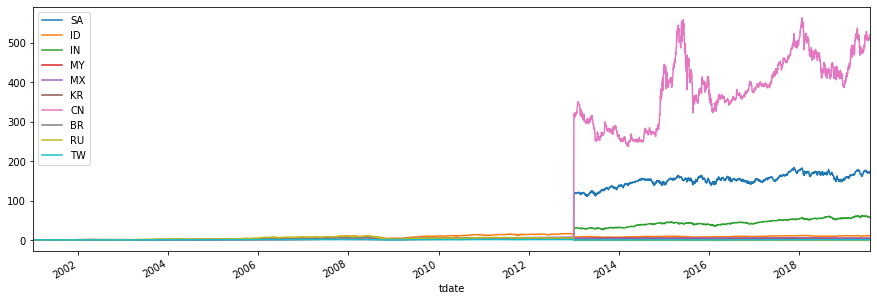

In [73]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

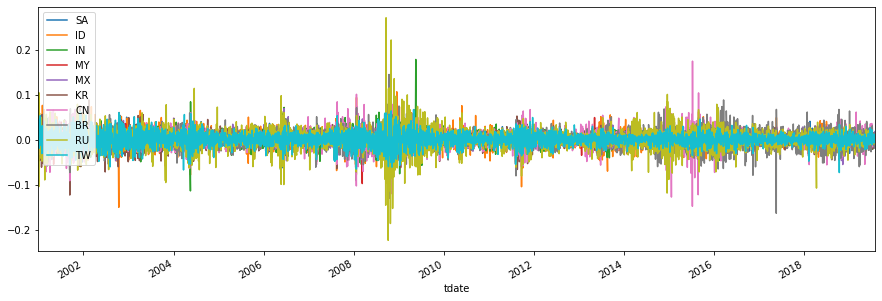

In [74]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [75]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### moving average 와 주가 차이

In [76]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [77]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [78]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [79]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EMPM_PAST.png">

<img src="./result/EMPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [80]:
one_week = 5
one_month = 20

In [81]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [82]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [83]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [84]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [85]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [86]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [87]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692384	valid_1's binary_logloss: 0.692384
[20]	training's binary_logloss: 0.691677	valid_1's binary_logloss: 0.691677
[30]	training's binary_logloss: 0.691023	valid_1's binary_logloss: 0.691023
[40]	training's binary_logloss: 0.690401	valid_1's binary_logloss: 0.690401
[50]	training's binary_logloss: 0.689812	valid_1's binary_logloss: 0.689812
[60]	training's binary_logloss: 0.689273	valid_1's binary_logloss: 0.689273
[70]	training's binary_logloss: 0.688768	valid_1's binary_logloss: 0.688768
[80]	training's binary_logloss: 0.688286	valid_1's binary_logloss: 0.688286
[90]	training's binary_logloss: 0.687794	valid_1's binary_logloss: 0.687794
[100]	training's binary_logloss: 0.687327	valid_1's binary_logloss: 0.687327
[110]	training's binary_logloss: 0.686884	valid_1's binary_logloss: 0.686884
[120]	training's binary_logloss: 0.686461	valid_1's binary_logloss: 0.686461
[130]	training's binary

In [88]:
test_pred = model.predict(df_test_x.values)

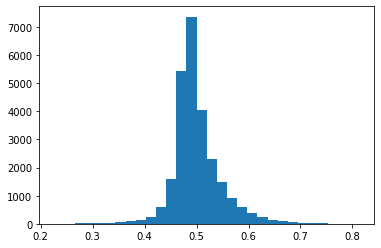

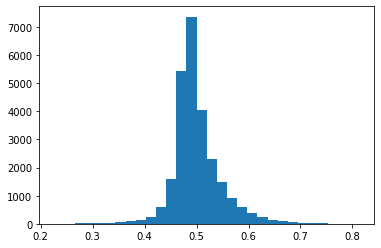

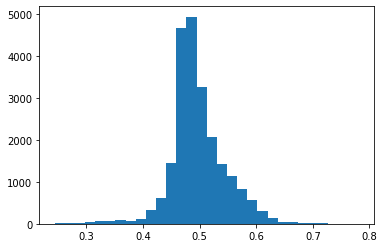

In [89]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [90]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [92]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [93]:
df_index_sub = df_index.loc['1994':]

In [94]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [95]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [96]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 09:30:23,323 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:23,323 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:23,323 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:23,323 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:23,323 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [97]:
tester = Tester(strategy)

In [98]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [99]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 09:30:23,355 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:23,355 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:23,355 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:23,355 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:23,355 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:23,357 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:30:23,357 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:30:23,357 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:30:23,357 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:30:23,357 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:30:23,359 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:30:23,359 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:30:23,359 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:30:23,359 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:30:23

### TRAIN

2019-10-31 09:30:38,911 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:38,911 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:38,911 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:38,911 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:38,911 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:38,914 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:38,914 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:38,914 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:38,914 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:38,914 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:38,923 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:30:38,923 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:30:38,923 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:30:38,923 - EMPM - INF

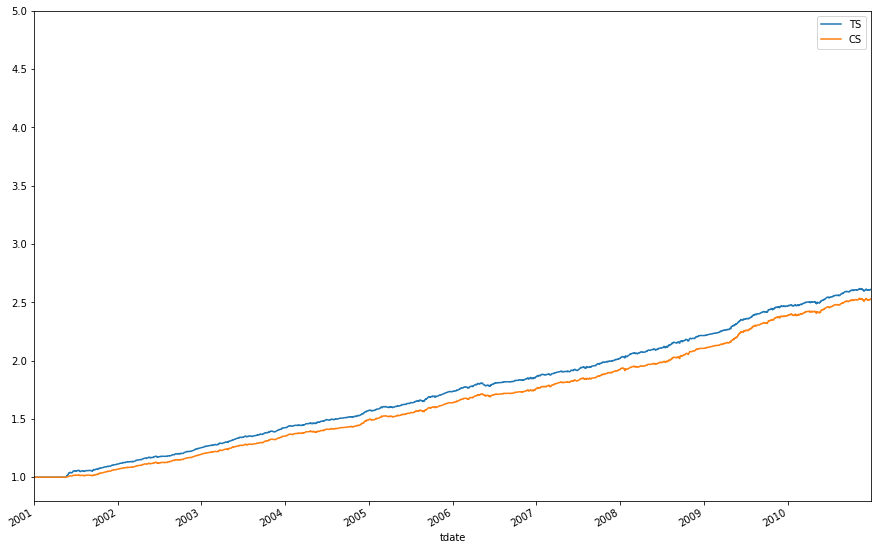

In [100]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:33:41,854 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:33:41,854 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:33:41,854 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:33:41,854 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:33:41,854 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:33:41,854 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:

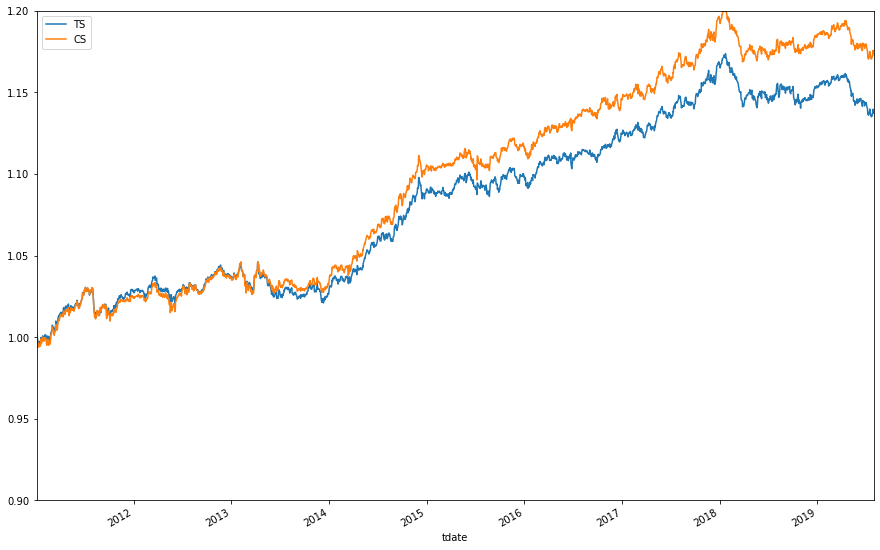

In [133]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.2))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [102]:
one_week = 5
one_week = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [103]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [104]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [105]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [106]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [107]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [108]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.690054	valid_1's binary_logloss: 0.693399
[20]	training's binary_logloss: 0.688798	valid_1's binary_logloss: 0.69331
[30]	training's binary_logloss: 0.687646	valid_1's binary_logloss: 0.693209
[40]	training's binary_logloss: 0.686619	valid_1's binary_logloss: 0.693148
[50]	training's binary_logloss: 0.685568	valid_1's binary_logloss: 0.692966
[60]	training's binary_logloss: 0.684609	valid_1's binary_logloss: 0.69284
[70]	training's binary_logloss: 0.683713	valid_1's binary_logloss: 0.692787
[80]	training's binary_logloss: 0.682854	valid_1's binary_logloss: 0.692866
[90]	training's binary_logloss: 0.681964	valid_1's binary_logloss: 0.69305
[100]	training's binary_logloss: 0.68124	valid_1's binary_logloss: 0.693329
[110]	training's binary_logloss: 0.680513	valid_1's binary_logloss: 0.693649
[120]	training's binary_logloss: 0.679805	valid_1's binary_logloss: 0.693926
[130]	training's binary_log

In [109]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([2.400e+01, 1.380e+02, 2.800e+02, 3.350e+02, 2.390e+02, 2.570e+02,
        2.220e+02, 1.440e+02, 1.580e+02, 2.650e+02, 5.350e+02, 2.317e+03,
        4.355e+03, 6.553e+03, 8.206e+03, 8.533e+03, 6.516e+03, 3.751e+03,
        2.164e+03, 1.415e+03, 8.060e+02, 4.850e+02, 2.610e+02, 1.980e+02,
        8.700e+01, 3.400e+01, 3.000e+01, 2.400e+01, 6.000e+00, 2.000e+00]),
 array([0.18430044, 0.20679943, 0.22929842, 0.25179741, 0.2742964 ,
        0.29679539, 0.31929438, 0.34179337, 0.36429236, 0.38679135,
        0.40929034, 0.43178933, 0.45428832, 0.47678731, 0.4992863 ,
        0.52178529, 0.54428428, 0.56678327, 0.58928226, 0.61178125,
        0.63428024, 0.65677923, 0.67927822, 0.70177721, 0.7242762 ,
        0.74677519, 0.76927418, 0.79177317, 0.81427216, 0.83677115,
        0.85927014]),
 <a list of 30 Patch objects>)

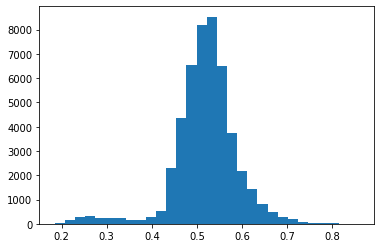

In [110]:
plt.hist(pred2, bins=30)

In [111]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [112]:
strategy2 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'
strategy2.ret.loc['2013-01-02'] = strategy2.ret.loc['2013-01-03']


strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-31 09:30:40,382 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:40,382 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:40,382 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:40,382 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:40,382 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:40,382 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:30:40,386 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:40,386 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:40,386 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:40,386 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:40,386 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:40,386 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:30:40,388 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:30:40,388 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:30:40,388 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:30:40

In [113]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-31 09:30:40,424 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:40,424 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:40,424 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:40,424 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:40,424 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:40,424 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:30:40,426 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:40,426 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:40,426 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:40,426 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:40,426 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:40,426 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:30:40,428 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:30:40,428 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:

### TRAIN

2019-10-31 09:30:53,877 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:53,877 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:53,877 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:53,877 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:53,877 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:53,877 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:53,879 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:53,879 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:53,879 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:53,879 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:53,879 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:53,879 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:53,887 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:30:53,887 - EMPM - INFO - [STEP 6 - 2] BACKTE

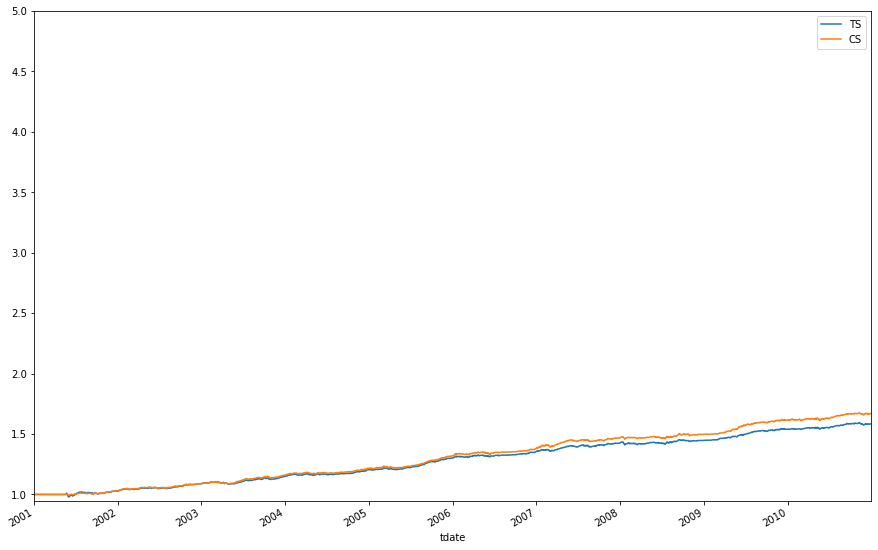

In [114]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-31 09:30:54,045 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:54,045 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:54,045 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:54,045 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:54,045 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:54,045 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:30:54,047 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:54,047 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:54,047 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:54,047 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:54,047 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:54,047 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:30:54,055 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:30:54,055 - EMPM - INFO - [STEP 6 - 2] BACKTE

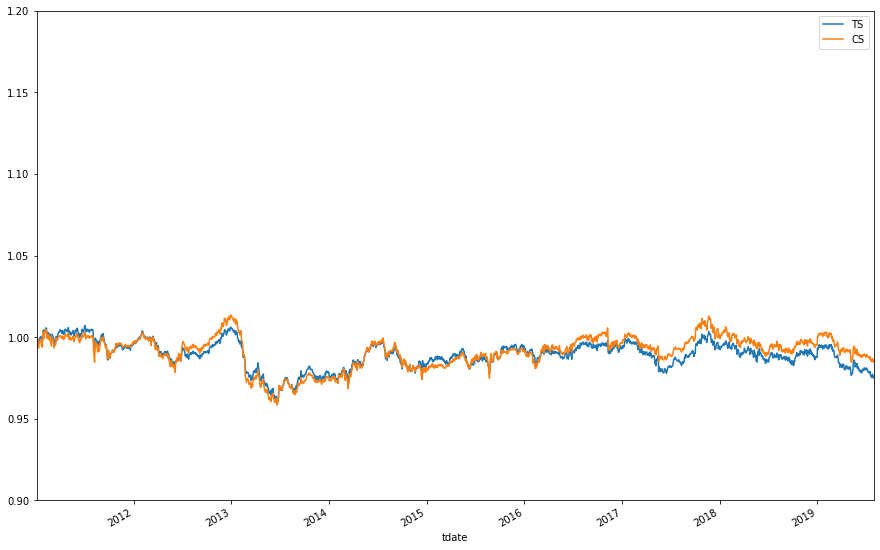

In [115]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 3. Case1을 Rolling으로 실행

In [116]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [117]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [118]:
models = []
train_preds = []
test_preds = []

In [119]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692384	valid_1's binary_logloss: 0.692567
[20]	training's binary_logloss: 0.691677	valid_1's binary_logloss: 0.692127
[30]	training's binary_logloss: 0.691023	valid_1's binary_logloss: 0.691823
[40]	training's binary_logloss: 0.690401	valid_1's binary_logloss: 0.691551
[50]	training's binary_logloss: 0.689812	valid_1's binary_logloss: 0.691383
[60]	training's binary_logloss: 0.689273	valid_1's binary_logloss: 0.691149
[70]	training's binary_logloss: 0.688768	valid_1's binary_logloss: 0.690873
[80]	training's binary_logloss: 0.688286	valid_1's binary_logloss: 0.69068
[90]	training's binary_logloss: 0.687794	valid_1's binary_logloss: 0.690472
[100]	training's binary_logloss: 0.687327	valid_1's binary_logloss: 0.690305
[110]	training's binary_logloss: 0.686884	valid_1's binary_logloss: 0.690145
[120]	training's binary_logloss: 0.686461	valid_1's binary_logloss: 0.690022
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692403	valid_1's binary_logloss: 0.692921
[20]	training's binary_logloss: 0.691727	valid_1's binary_logloss: 0.692757
[30]	training's binary_logloss: 0.691115	valid_1's binary_logloss: 0.69272
[40]	training's binary_logloss: 0.690528	valid_1's binary_logloss: 0.692699
[50]	training's binary_logloss: 0.69	valid_1's binary_logloss: 0.692712
[60]	training's binary_logloss: 0.689481	valid_1's binary_logloss: 0.692726
[70]	training's binary_logloss: 0.688973	valid_1's binary_logloss: 0.692786
[80]	training's binary_logloss: 0.688484	valid_1's binary_logloss: 0.692815
[90]	training's binary_logloss: 0.688005	valid_1's binary_logloss: 0.692941
[100]	training's binary_logloss: 0.687565	valid_1's binary_logloss: 0.693114
[110]	training's binary_logloss: 0.68718	valid_1's binary_logloss: 0.693124
[120]	training's binary_logloss: 0.686792	valid_1's binary_logloss: 0.693204
[130]	training's binary_loglo

[160]	training's binary_logloss: 0.686447	valid_1's binary_logloss: 0.692553
[170]	training's binary_logloss: 0.686155	valid_1's binary_logloss: 0.692575
[180]	training's binary_logloss: 0.685856	valid_1's binary_logloss: 0.692611
[190]	training's binary_logloss: 0.685577	valid_1's binary_logloss: 0.692547
[200]	training's binary_logloss: 0.685299	valid_1's binary_logloss: 0.692575
[210]	training's binary_logloss: 0.685018	valid_1's binary_logloss: 0.692554
[220]	training's binary_logloss: 0.684752	valid_1's binary_logloss: 0.692486
[230]	training's binary_logloss: 0.68448	valid_1's binary_logloss: 0.692445
[240]	training's binary_logloss: 0.684202	valid_1's binary_logloss: 0.6924
[250]	training's binary_logloss: 0.683944	valid_1's binary_logloss: 0.692442
[260]	training's binary_logloss: 0.683671	valid_1's binary_logloss: 0.692403
[270]	training's binary_logloss: 0.683407	valid_1's binary_logloss: 0.692289
[280]	training's binary_logloss: 0.683165	valid_1's binary_logloss: 0.692295
[2

[320]	training's binary_logloss: 0.68296	valid_1's binary_logloss: 0.691474
[330]	training's binary_logloss: 0.682722	valid_1's binary_logloss: 0.691393
[340]	training's binary_logloss: 0.682499	valid_1's binary_logloss: 0.691388
[350]	training's binary_logloss: 0.682265	valid_1's binary_logloss: 0.691391
[360]	training's binary_logloss: 0.682031	valid_1's binary_logloss: 0.691367
[370]	training's binary_logloss: 0.68181	valid_1's binary_logloss: 0.691365
[380]	training's binary_logloss: 0.681588	valid_1's binary_logloss: 0.691376
[390]	training's binary_logloss: 0.68137	valid_1's binary_logloss: 0.691335
[400]	training's binary_logloss: 0.681166	valid_1's binary_logloss: 0.691335
[410]	training's binary_logloss: 0.680885	valid_1's binary_logloss: 0.691249
[420]	training's binary_logloss: 0.680659	valid_1's binary_logloss: 0.691227
[430]	training's binary_logloss: 0.680395	valid_1's binary_logloss: 0.691179
[440]	training's binary_logloss: 0.680135	valid_1's binary_logloss: 0.691154
[4

[470]	training's binary_logloss: 0.680747	valid_1's binary_logloss: 0.689596
[480]	training's binary_logloss: 0.680539	valid_1's binary_logloss: 0.689604
[490]	training's binary_logloss: 0.680366	valid_1's binary_logloss: 0.689572
[500]	training's binary_logloss: 0.680165	valid_1's binary_logloss: 0.68952
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.680165	valid_1's binary_logloss: 0.68952
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692614	valid_1's binary_logloss: 0.692907
[20]	training's binary_logloss: 0.692141	valid_1's binary_logloss: 0.692721
[30]	training's binary_logloss: 0.691713	valid_1's binary_logloss: 0.692645
[40]	training's binary_logloss: 0.69132	valid_1's binary_logloss: 0.692664
[50]	training's binary_logloss: 0.690949	valid_1's binary_logloss: 0.692673
[60]	training's binary_logloss: 0.690597	valid_1's binary_logloss: 0.692575
[70]	training's binary_logloss: 0.690272	valid_1's b

In [120]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([5.000e+00, 6.000e+00, 3.000e+00, 2.000e+01, 4.700e+01, 5.100e+01,
        6.000e+01, 1.110e+02, 1.740e+02, 2.840e+02, 5.310e+02, 1.015e+03,
        3.242e+03, 5.782e+03, 4.410e+03, 2.613e+03, 1.410e+03, 8.540e+02,
        6.520e+02, 5.210e+02, 2.910e+02, 1.410e+02, 5.200e+01, 2.200e+01,
        1.600e+01, 1.500e+01, 5.000e+00, 4.000e+00, 4.000e+00, 9.000e+00]),
 array([0.26421086, 0.28051121, 0.29681155, 0.31311189, 0.32941223,
        0.34571257, 0.36201291, 0.37831326, 0.3946136 , 0.41091394,
        0.42721428, 0.44351462, 0.45981496, 0.47611531, 0.49241565,
        0.50871599, 0.52501633, 0.54131667, 0.55761701, 0.57391736,
        0.5902177 , 0.60651804, 0.62281838, 0.63911872, 0.65541906,
        0.67171941, 0.68801975, 0.70432009, 0.72062043, 0.73692077,
        0.75322111]),
 <a list of 30 Patch objects>)

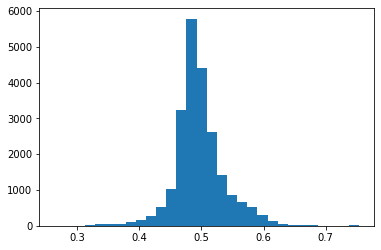

In [121]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [122]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [123]:
strategy3 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'
strategy3.ret.loc['2013-01-02'] = strategy3.ret.loc['2013-01-03']


strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-31 09:31:01,130 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:01,130 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:01,130 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:01,130 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:01,130 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:01,130 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:01,130 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:01,134 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:01,134 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:01,134 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:01,134 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:01,134 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:01,134 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:01,134 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:01,136 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:31:01,136 - EMPM - INFO 

In [124]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-31 09:31:01,171 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:01,171 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:01,171 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:01,171 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:01,171 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:01,171 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:01,171 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:01,174 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:01,174 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:01,174 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:01,174 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:01,174 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:01,174 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:01,174 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER

2019-10-31 09:31:11,444 - EMPM - INFO - [STEP 5 - 4] SAVE POSITION
2019-10-31 09:31:11,444 - EMPM - INFO - [STEP 5 - 4] SAVE POSITION
2019-10-31 09:31:11,444 - EMPM - INFO - [STEP 5 - 4] SAVE POSITION
2019-10-31 09:31:11,444 - EMPM - INFO - [STEP 5 - 4] SAVE POSITION
2019-10-31 09:31:11,444 - EMPM - INFO - [STEP 5 - 4] SAVE POSITION


2019-10-31 09:31:11,513 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:11,513 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:11,513 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:11,513 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:11,513 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:11,513 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:11,513 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:11,517 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:11,517 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:11,517 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:11,517 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:11,517 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:11,517 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:11,517 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES

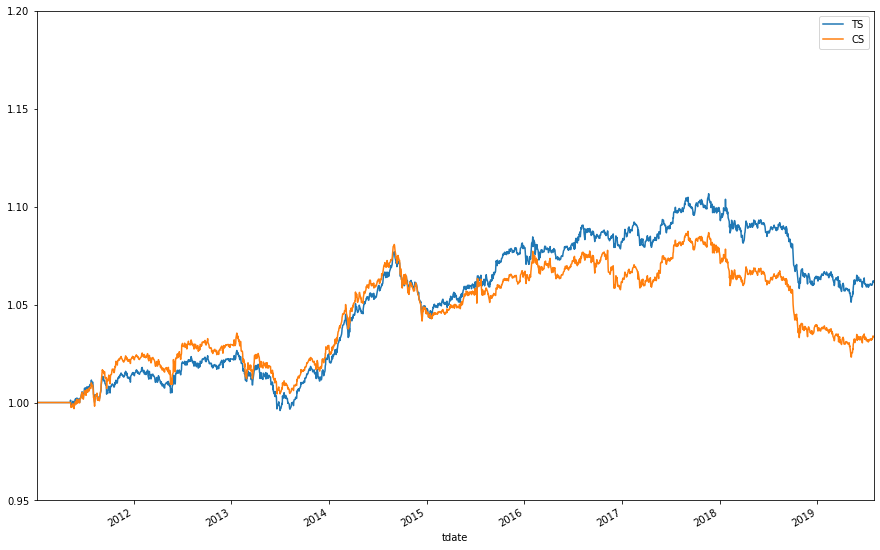

In [125]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))

# CASE 4. CASE 2를 ROLLING으로 실행

In [126]:
models = []
train_preds = []
test_preds = []

In [127]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.690054	valid_1's binary_logloss: 0.694231
[20]	training's binary_logloss: 0.688798	valid_1's binary_logloss: 0.693963
[30]	training's binary_logloss: 0.687646	valid_1's binary_logloss: 0.693818
[40]	training's binary_logloss: 0.686619	valid_1's binary_logloss: 0.693853
[50]	training's binary_logloss: 0.685568	valid_1's binary_logloss: 0.693833
[60]	training's binary_logloss: 0.684609	valid_1's binary_logloss: 0.693824
[70]	training's binary_logloss: 0.683713	valid_1's binary_logloss: 0.693822
[80]	training's binary_logloss: 0.682854	valid_1's binary_logloss: 0.6938
[90]	training's binary_logloss: 0.681964	valid_1's binary_logloss: 0.693951
[100]	training's binary_logloss: 0.68124	valid_1's binary_logloss: 0.694018
[110]	training's binary_logloss: 0.680513	valid_1's binary_logloss: 0.694123
[120]	training's binary_logloss: 0.679805	valid_1's binary_logloss: 0.694186
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.68999	valid_1's binary_logloss: 0.694924
[20]	training's binary_logloss: 0.688767	valid_1's binary_logloss: 0.695009
[30]	training's binary_logloss: 0.687688	valid_1's binary_logloss: 0.695152
[40]	training's binary_logloss: 0.686636	valid_1's binary_logloss: 0.694948
[50]	training's binary_logloss: 0.685698	valid_1's binary_logloss: 0.694897
[60]	training's binary_logloss: 0.684769	valid_1's binary_logloss: 0.694791
[70]	training's binary_logloss: 0.683855	valid_1's binary_logloss: 0.694414
[80]	training's binary_logloss: 0.68305	valid_1's binary_logloss: 0.693928
[90]	training's binary_logloss: 0.682256	valid_1's binary_logloss: 0.693538
[100]	training's binary_logloss: 0.681512	valid_1's binary_logloss: 0.693556
[110]	training's binary_logloss: 0.680818	valid_1's binary_logloss: 0.693561
[120]	training's binary_logloss: 0.680044	valid_1's binary_logloss: 0.693657
[130]	training's binary_l

[170]	training's binary_logloss: 0.678	valid_1's binary_logloss: 0.692897
[180]	training's binary_logloss: 0.677477	valid_1's binary_logloss: 0.692816
[190]	training's binary_logloss: 0.676997	valid_1's binary_logloss: 0.692838
[200]	training's binary_logloss: 0.676511	valid_1's binary_logloss: 0.692921
[210]	training's binary_logloss: 0.676031	valid_1's binary_logloss: 0.692644
[220]	training's binary_logloss: 0.675596	valid_1's binary_logloss: 0.692671
[230]	training's binary_logloss: 0.675066	valid_1's binary_logloss: 0.692737
[240]	training's binary_logloss: 0.674657	valid_1's binary_logloss: 0.692731
[250]	training's binary_logloss: 0.674122	valid_1's binary_logloss: 0.692742
[260]	training's binary_logloss: 0.673591	valid_1's binary_logloss: 0.692801
[270]	training's binary_logloss: 0.673158	valid_1's binary_logloss: 0.692667
[280]	training's binary_logloss: 0.672627	valid_1's binary_logloss: 0.692602
[290]	training's binary_logloss: 0.672202	valid_1's binary_logloss: 0.692502
[3

[290]	training's binary_logloss: 0.672588	valid_1's binary_logloss: 0.698435
[300]	training's binary_logloss: 0.672157	valid_1's binary_logloss: 0.698473
[310]	training's binary_logloss: 0.67177	valid_1's binary_logloss: 0.698544
[320]	training's binary_logloss: 0.671418	valid_1's binary_logloss: 0.698598
[330]	training's binary_logloss: 0.671	valid_1's binary_logloss: 0.698668
[340]	training's binary_logloss: 0.670632	valid_1's binary_logloss: 0.698763
[350]	training's binary_logloss: 0.670265	valid_1's binary_logloss: 0.698838
[360]	training's binary_logloss: 0.669848	valid_1's binary_logloss: 0.698832
[370]	training's binary_logloss: 0.669484	valid_1's binary_logloss: 0.698832
[380]	training's binary_logloss: 0.669025	valid_1's binary_logloss: 0.698765
[390]	training's binary_logloss: 0.668572	valid_1's binary_logloss: 0.698683
[400]	training's binary_logloss: 0.668102	valid_1's binary_logloss: 0.698805
[410]	training's binary_logloss: 0.66762	valid_1's binary_logloss: 0.698756
[420

[310]	training's binary_logloss: 0.673724	valid_1's binary_logloss: 0.696761
[320]	training's binary_logloss: 0.673285	valid_1's binary_logloss: 0.696752
[330]	training's binary_logloss: 0.672901	valid_1's binary_logloss: 0.696837
[340]	training's binary_logloss: 0.672479	valid_1's binary_logloss: 0.696852
[350]	training's binary_logloss: 0.672076	valid_1's binary_logloss: 0.696953
[360]	training's binary_logloss: 0.671721	valid_1's binary_logloss: 0.697253
[370]	training's binary_logloss: 0.671364	valid_1's binary_logloss: 0.697508
[380]	training's binary_logloss: 0.670951	valid_1's binary_logloss: 0.697585
[390]	training's binary_logloss: 0.670605	valid_1's binary_logloss: 0.697749
[400]	training's binary_logloss: 0.670231	valid_1's binary_logloss: 0.697741
[410]	training's binary_logloss: 0.669863	valid_1's binary_logloss: 0.697834
[420]	training's binary_logloss: 0.669504	valid_1's binary_logloss: 0.697839
[430]	training's binary_logloss: 0.669127	valid_1's binary_logloss: 0.697902

In [128]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [129]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [130]:
strategy4 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'
strategy4.ret.loc['2013-01-02'] = strategy4.ret.loc['2013-01-03']


strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,633 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:31:17,639 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:17,639 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:17,639 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:17,639 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:17,639 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:17,639 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:17,639 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:31:17,639 - EMPM - INFO - [ST

In [131]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,682 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:31:17,684 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:17,684 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:17,684 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:17,684 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:17,684 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:31:17,684 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
20

2019-10-31 09:31:27,108 - EMPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31 09:31:27,108 - EMPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31 09:31:27,108 - EMPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,583 - EMPM - INFO - [STEP 5 - 3 - 4] MAKE FINAL CS POSITION
2019-10-31 09:31:27,589 - EMPM - INFO - [STEP 5 - 4] SAVE POSIT

2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,660 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:31:27,663 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:27,663 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:27,663 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:27,663 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:27,663 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:31:27,663 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:

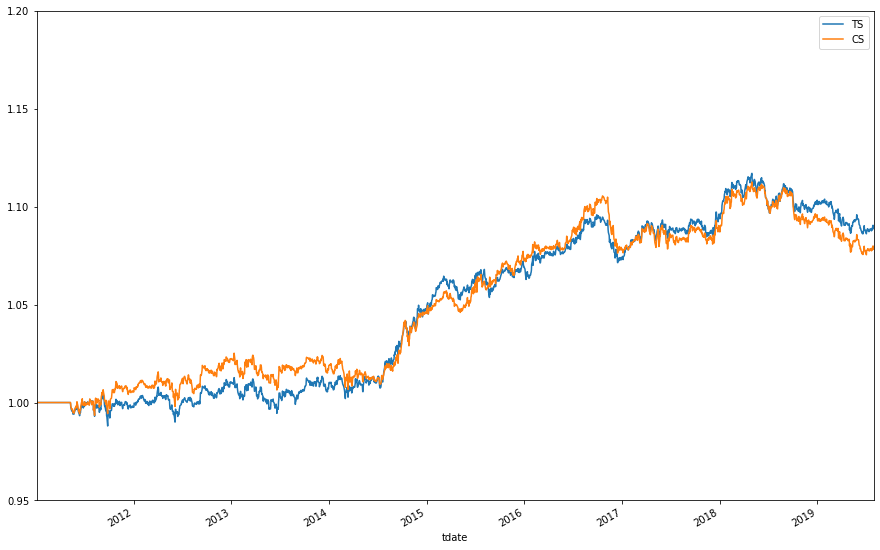

In [132]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))